In [1]:
# Library imports
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn import utils
from imutils import paths
import numpy as np
import imutils
import random
import cv2
import os
import json
import matplotlib.pyplot as plt
import time

In [2]:
# for a bigger display
import matplotlib
matplotlib.rcParams['figure.figsize']= (20,20)

In [3]:
# path variables
model_path= "neoexp_logs/neoplast20210228T1521/mask_rcnn_neoplast_0049.h5"
test_img_path= "datset/val_img_paths.txt"

In [4]:
# for loading configurations
img_path= "datset/images"
mask_path= "datset/masks"
CLASS_NAMES = {1:"NeoPlast"}
CLASS_COLORS={1:(1.0,0.0,0.0)}
COCO_PATH = "mask_rcnn_coco.h5"
LOGS_AND_MODEL_DIR = "neoexp_logs"

In [5]:
# load data
data_split= 0.8
exp_split= 1.0
#random.seed(36)

In [6]:
img_path_list= sorted(list(paths.list_images(img_path)))

In [7]:
exp_img_num= int(len(img_path_list)*exp_split)
exp_ids= [random.randint(0, len(img_path_list)-1) for i in range(exp_img_num)]
exp_img_pathlist= np.array(img_path_list)[exp_ids]

In [8]:
idx= list(range(0, len(exp_img_pathlist)))
random.shuffle(idx)
num_train= int((len(exp_img_pathlist)-500)* data_split)
trainIdxs= idx[:num_train]
valIdxs= idx[num_train:len(idx)-500]
testIdxs= idx[len(idx)-500:]

In [9]:
# create a sub-class and inherit the primary configuration class
class NeoPlastConfig(Config):
    # give the configuration a name
    NAME = "NeoPlast"

    # set the number of GPUs to use training along with the number of
    # images per GPU which acts as the batch size
    # set other hyperparameters in config file
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    LEARNING_RATE= 0.001
    RPN_NMS_THRESHOLD= 0.8
    WEIGHT_DECAY= 0.0001

    # set the number of steps per training epoch and validation cycle
    STEPS_PER_EPOCH = len(trainIdxs) // (IMAGES_PER_GPU * GPU_COUNT)
    VALIDATION_STEPS = len(valIdxs) // (IMAGES_PER_GPU * GPU_COUNT)

    # number of classes (+1 for the background)
    NUM_CLASSES = len(CLASS_NAMES) + 1

In [10]:
# class inherited from the initial config file
# and stores inference configurations
class NeoPlastInferenceConfig(NeoPlastConfig):
    # set the number of GPUs and images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # set the minimum detection confidence (used to prune out false
    # positive detections)
    DETECTION_MIN_CONFIDENCE = 0.8

In [11]:
# load the configuration class
# set model into inference mode
# load trained weights
inference_config = NeoPlastInferenceConfig()
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=LOGS_AND_MODEL_DIR)
model.load_weights(model_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Re-starting from epoch 49


In [12]:
# read the test data paths and extract img paths
with open(test_img_path, "r") as f:
    test_arr= f.readlines()
    test_arr= [a.splitlines()[0] for a in test_arr]
    f.close()

Processing 1 images
image                    shape: (256, 256, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

Mean Confidence Score of Image 1= 0.9357272982597351

Processing 1 images
image                    shape: (256, 256, 3)         min:    5.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

Mean Confidence Score of Image 2= 0.9611153602600098

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00

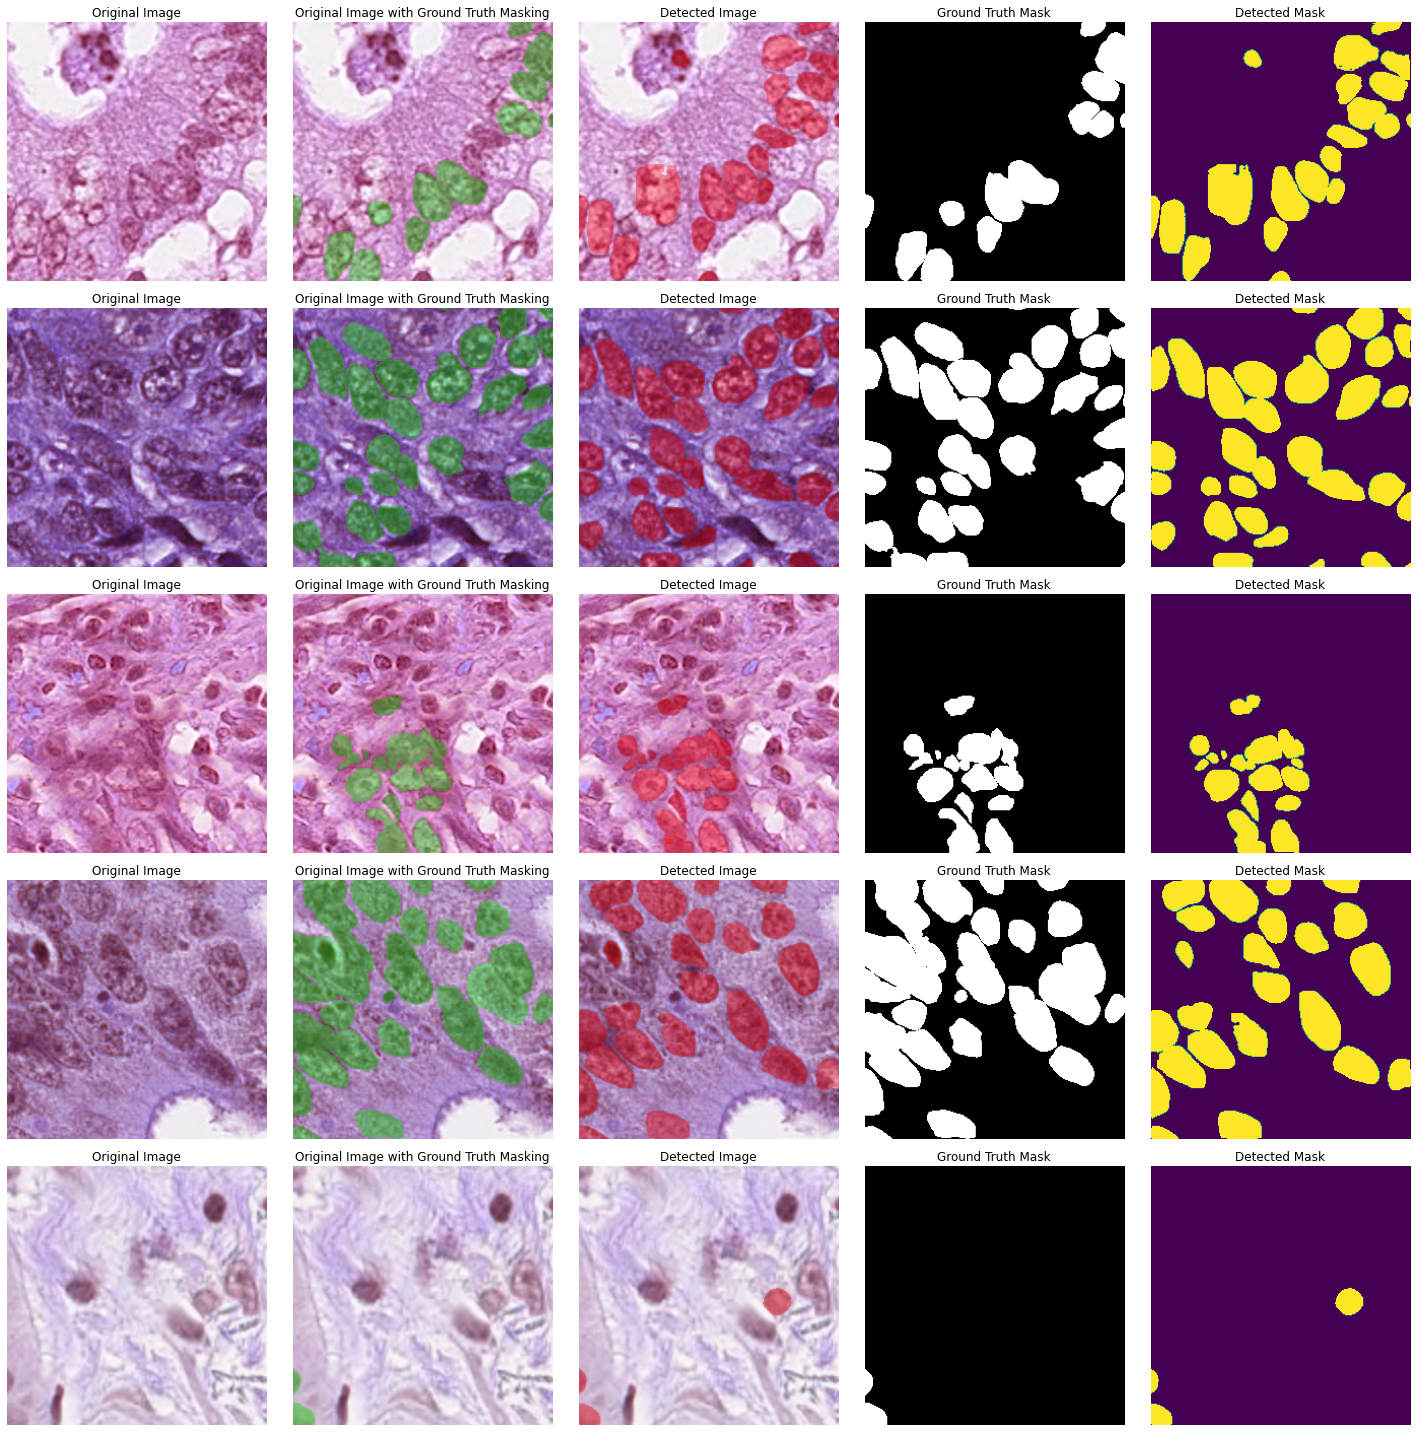

In [17]:
# set a display number and randomly select those images
num_to_display=5
random_index= [random.randint(0, len(test_arr)-1) for _ in range(num_to_display)]

start_time= time.time()
img_count=1
num_cell_labelled= 0
for count,r in enumerate(random_index):
    # load the image
    inf_img_path= test_arr[r]
    image = cv2.imread(inf_img_path)
    # make a copy for display
    ori_image= image.copy()
    image_mask_forgt= image.copy()
    # correct channels for inference
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = imutils.resize(image, width=256)
    # grab corresponding mask path for reference
    get_corr_mask_path= mask_path+"\\mask_"+inf_img_path.split('\\')[-1].split('_')[-1]
    # get predictions from model
    R = model.detect([image], verbose=1)[0]
    num_cell_labelled+= len(R['scores'])
    
    # apply an alpha-blended mask to the image
    for i in range(0, R["rois"].shape[0]):
        mask = R["masks"][:, :, i]
        if R["class_ids"][i] in [1]:
            image_result = visualize.apply_mask(image, mask,
                                     CLASS_COLORS[R['class_ids'][i]], alpha=0.35)
    
    # load ground-truth mask for display
    dis_img_mask= cv2.imread(get_corr_mask_path)
    dis_img_mask_forgt= dis_img_mask.copy()
    dis_img_mask[dis_img_mask>0]=255
    dis_img_mask_forgt[dis_img_mask_forgt>0]=1
    dis_img_mask_forgt= cv2.split(dis_img_mask_forgt)[0]
    gt_masked_image = visualize.apply_mask(image_mask_forgt, dis_img_mask_forgt,
                                     (0.0, 1.0, 0.0), alpha=0.35)
    
    # Generate an empty container for merging instance
    # wise masks
    mask_result= np.zeros((256,256), dtype='bool')
    for i in range(R['masks'].shape[2]):
        mask_result+=R['masks'][:,:,i]
    mask_result= mask_result.astype('float')
    
    # display the images
    plt.tight_layout()
    plt.subplot(num_to_display,5,img_count);
    plt.title('Original Image')
    plt.axis('off');
    plt.imshow(ori_image[:,:,::-1])
    img_count+=1
    
    plt.subplot(num_to_display,5,img_count);
    plt.title('Original Image with Ground Truth Masking')
    plt.axis('off');
    plt.imshow(gt_masked_image[:,:,::-1])
    img_count+=1
    
    plt.subplot(num_to_display,5,img_count);
    plt.title('Detected Image')
    plt.axis('off');
    plt.imshow(image_result);
    img_count+=1
    
    plt.subplot(num_to_display,5,img_count);
    plt.title('Ground Truth Mask')
    plt.axis('off');
    plt.imshow(dis_img_mask);
    img_count+=1
    
    plt.subplot(num_to_display,5,img_count);
    plt.title('Detected Mask')
    plt.axis('off');
    plt.imshow(mask_result);
    img_count+=1
    
    # calculate and print mean support confidence per image
    print("\nMean Confidence Score of Image {}= {}\n".format(count+1, R['scores'].mean()))
    
print('{} cells labelled in {:.2f}s'.format(num_cell_labelled, time.time()-start_time))

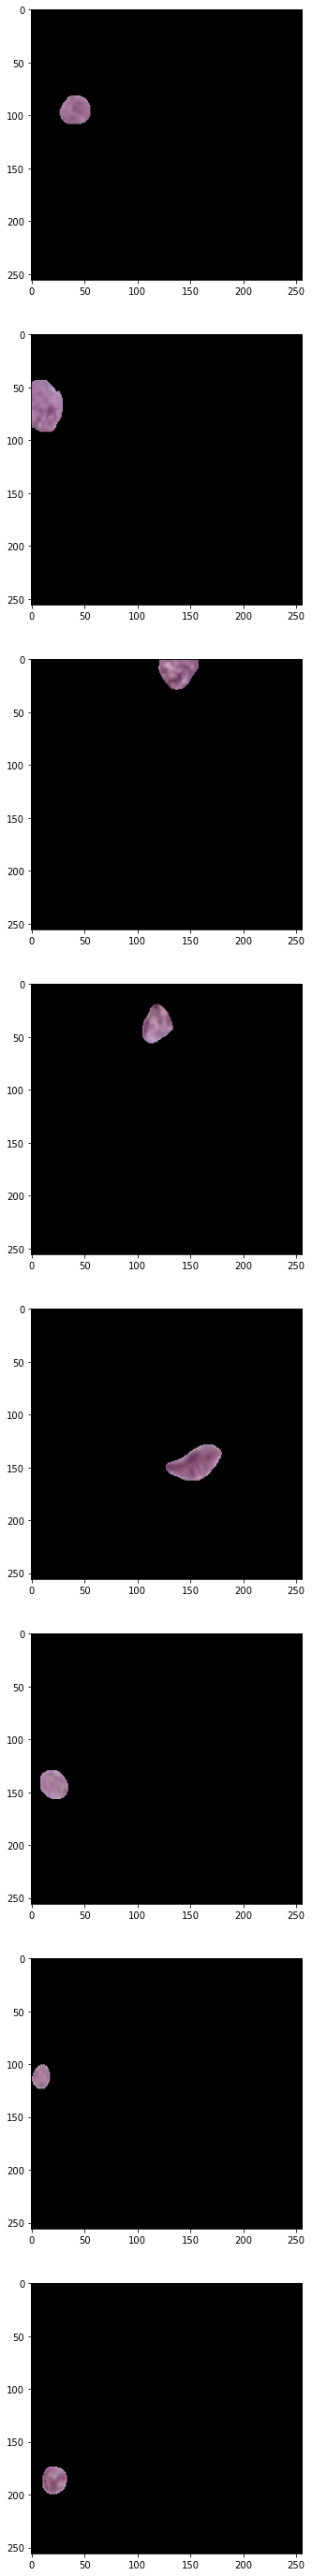

In [16]:
# Example of instance segmentation
# Extracting each detected cell for further study
# Using alpha-blending technique
plt.figure(figsize=(50,50))
img_length= R['masks'].shape[-1]
for i in range(img_length):
    current_cell= R['masks'][:,:,i]
    current_cell= current_cell.astype('float')
    current_cell_mask= cv2.merge((current_cell, current_cell, current_cell))
    cell_patch= cv2.multiply(current_cell_mask, ori_image.astype('float'))
    cell_patch/=255
    plt.subplot(img_length, 1, i+1)
    plt.imshow(cell_patch[:,:,::-1])